### **Dimensionality Reduction**

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import procrustes
from scipy.stats import pearsonr
import tensorflow as tf
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time
import seaborn as sns
from IPython.display import display
import cv2
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.offsetbox as offsetbox
import zipfile
from PIL import Image

**Extracting the 360 Rocks Zip File**

In [7]:
# Provide the absolute path to the zip file
zip_path = 'C:/Users/Harsha Vardhan K/Downloads/360 Rocks.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/360_Rocks')  # Or your desired extraction path

**Loading the Image Data and Label Data**

In [9]:
def load_images(folder, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, img_size)
            flat_images = img_resized.flatten()
            images.append(flat_images)
            if filename.startswith('I'):
              labels.append('Igneous')
            elif filename.startswith('M'):
              labels.append('Metamorphic')
            elif filename.startswith('S'):
              labels.append('Sedimentary')
    return np.array(images), np.array(labels)

images, labels = load_images('/content/360_Rocks')
print("Shape of Images Array:",images.shape)
print("Shape of Labels Array:",labels.shape)

Shape of Images Array: (360, 4096)
Shape of Labels Array: (360,)


The load_images function reads image files from a specified folder, resizes them to 64x64 pixels, and flattens each image into a 1D array. The images are loaded in grayscale, and the function assigns labels based on the filenames (Igneous, Metamorphic, or Sedimentary) using prefix matching. The output is a NumPy array of images with shape (360, 4096) and a corresponding label array of shape (360,), representing 360 samples with flattened pixel values and their class labels.

**[1] Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?**

In [12]:
pca = PCA()
pca.fit(images)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_variance_ratio >= 0.90) + 1
print(f'Number of components needed to preserve 90% of the variance: {n_components_90}')

Number of components needed to preserve 90% of the variance: 147


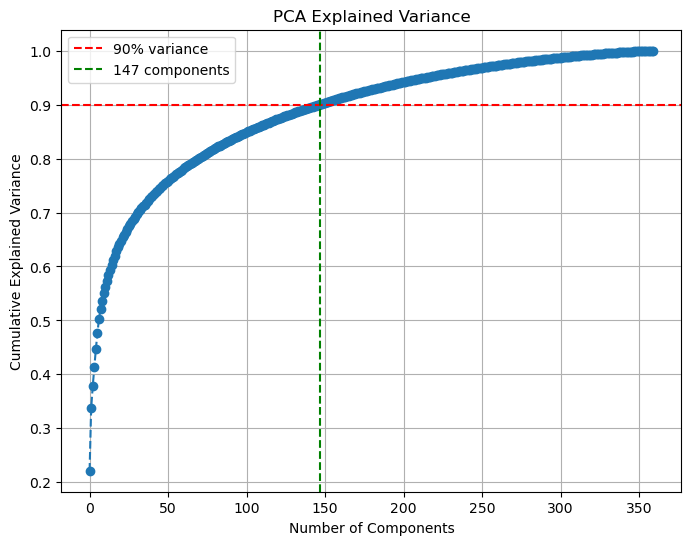

In [13]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Find the number of components required to preserve 90% variance
components_90 = np.argmax(cumulative_variance >= 0.90) + 1
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axvline(x=components_90, color='g', linestyle='--', label=f'{components_90} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid()
plt.show()

The plot shows the cumulative explained variance by the number of principal components (PCs) in a PCA analysis. The red dashed line indicates the 90% variance threshold, and the green dashed line shows the number of PCs needed to reach this threshold (147 PCs).

**[2] Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.**

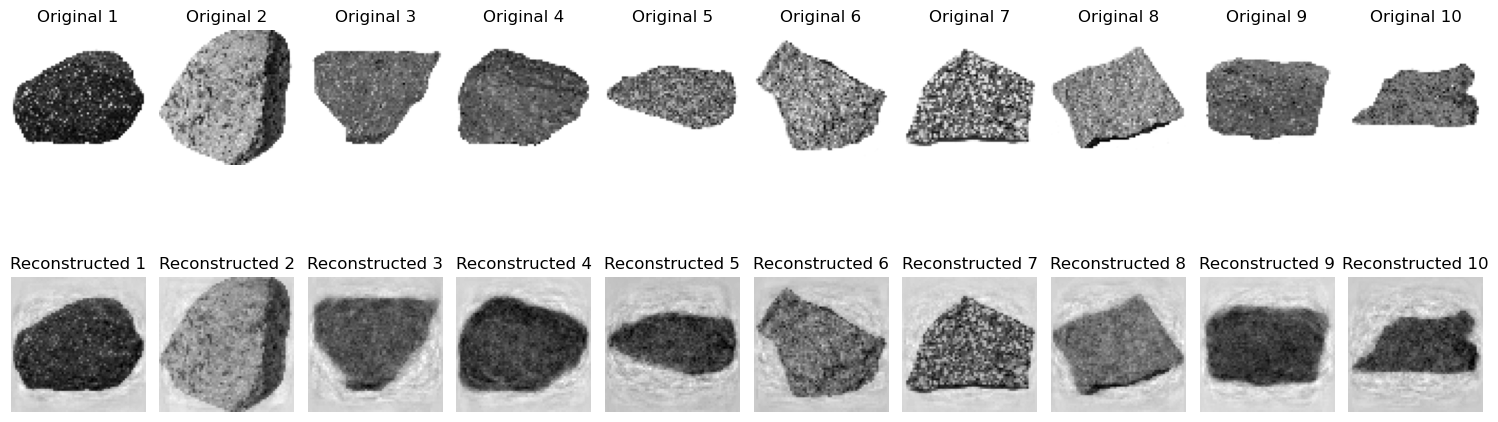

In [16]:
pca_90 = PCA(n_components=n_components_90)
images_pca = pca_90.fit_transform(images)

# Reconstruct the images from the PCA components (projection back to the original space)
images_reconstructed = pca_90.inverse_transform(images_pca)

# Plot 10 original images and their reconstructed versions
fig, axes = plt.subplots(2, 10, figsize=(15, 6))  # Create a 2x10 grid of subplots
axes = axes.flatten()  # Flatten the axes for easier indexing

# Plot original images
for i in range(10):
    axes[i].imshow(images[i].reshape(64, 64), cmap='gray')  # Reshape to original image size (64x64)
    axes[i].axis('off')  # Turn off axes
    axes[i].set_title(f'Original {i+1}')

# Plot reconstructed images
for i in range(10):
    axes[10 + i].imshow(images_reconstructed[i].reshape(64, 64), cmap='gray')  # Reshape to original image size (64x64)
    axes[10 + i].axis('off')  # Turn off axes
    axes[10 + i].set_title(f'Reconstructed {i+1}')

# Adjust layout for better spacing between images
plt.tight_layout(pad=1.0)  # Add padding between subplots
plt.show()


The above code uses PCA to reduce the dimensionality of the image dataset while retaining 90% of the variance, then reconstructs the images by projecting them back into the original space. It plots 10 randomly selected original grayscale images (64x64 pixels) alongside their reconstructed counterparts. This visualization demonstrates how PCA preserves key features of the images even after dimensionality reduction.

**[3] Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.**

**[3][A] Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**

In [20]:
# Apply PCA to reduce to 2 components
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(images)
print(pca_result_2d)

[[ 2.64692924e+03  1.73130937e+03]
 [ 4.99258080e+02 -1.63961702e+03]
 [-4.34829741e+02 -1.90748587e+02]
 [ 1.79812186e+02  3.86491259e+02]
 [-2.55357665e+03  4.73093313e+02]
 [-8.18621640e+02 -5.72532034e+02]
 [-5.08381907e+02 -3.74941661e+01]
 [-1.22518303e+03  9.81984033e+01]
 [-5.82318603e+02  9.74853880e+02]
 [-2.17438875e+03  8.35603891e+02]
 [-2.27368839e+03 -1.40901682e+02]
 [-1.33261115e+03  1.12538664e+02]
 [ 2.78797785e+03 -1.68408583e+03]
 [ 1.45084728e+03 -6.18603999e+02]
 [ 1.45999516e+03 -1.22068664e+03]
 [ 4.59163551e+03 -1.38838125e+03]
 [ 4.05687499e+03 -1.66693912e+03]
 [ 2.95821597e+03 -6.95580532e+01]
 [ 4.94081563e+02 -3.68096066e+02]
 [ 4.08950337e+03 -2.51061015e+03]
 [ 1.19048623e+03  6.53419381e+02]
 [ 3.44486281e+03  1.49057412e+03]
 [-7.99898069e+02  9.70661948e+02]
 [ 5.59288854e+02  5.09829640e+01]
 [ 2.81696225e+03 -1.89531516e+03]
 [ 2.12200420e+03  4.72611650e+02]
 [ 7.26949619e+02 -1.19568918e+03]
 [-2.01784602e+02 -7.25029005e+01]
 [-4.64698839e+02  1

In [21]:
# Variance explained by the first 2 components
variance_explained = sum(pca_2d.explained_variance_ratio_) * 100
print(f"Variance explained by the first 2 PCA components: {variance_explained:.2f}%")

Variance explained by the first 2 PCA components: 33.67%


**[3][B] Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS.**

In [23]:
print(labels)

['Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous' 'Igneous'
 'Igne

**PCA 2D Scatter Plot**

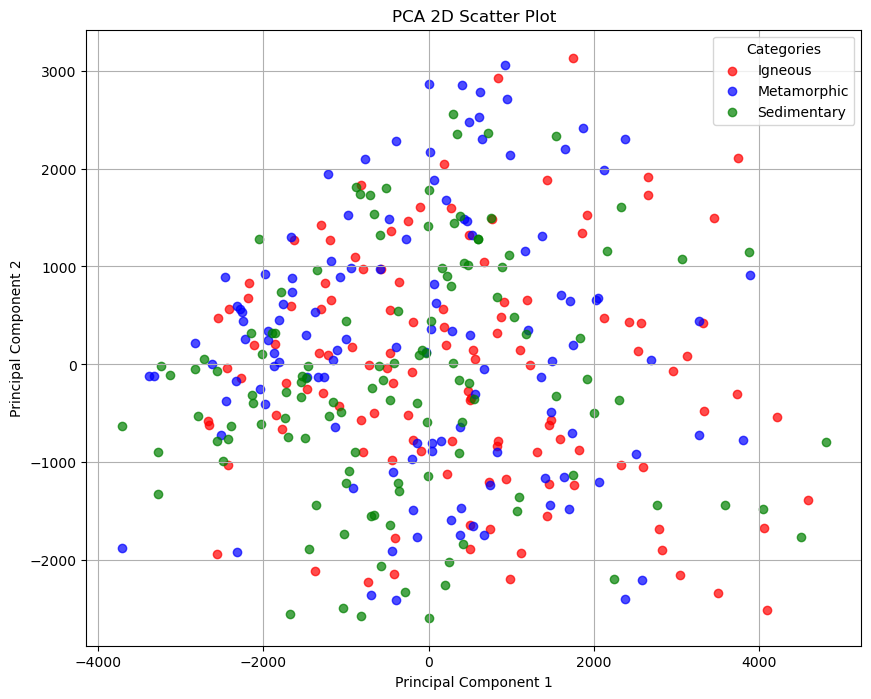

In [25]:
# Scatter plot with category coloring
category_colors = {'Igneous': 'red', 'Metamorphic': 'blue', 'Sedimentary': 'green'}
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    idx = [i for i, label in enumerate(labels) if label == category]  # Use labels directly
    plt.scatter(pca_result_2d[idx, 0], pca_result_2d[idx, 1], c=color, label=category, alpha=0.7)

plt.title('PCA 2D Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Categories")
plt.grid()
plt.show()

**PCA 2D Scatter Plot with images**

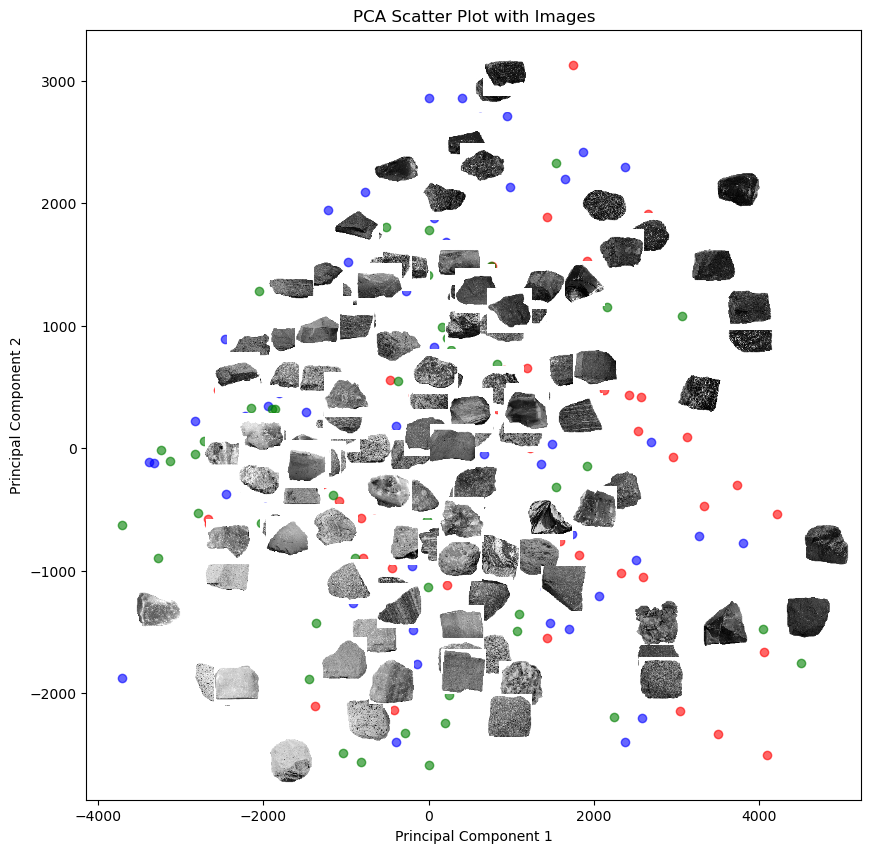

In [27]:
def plot_pca_with_images(data_2d, images, labels, colors, n_images=100):
    # Create a figure
    plt.figure(figsize=(10,10))

    # Plot scatter points with different colors for each label
    for i, (x, y) in enumerate(data_2d):
        plt.scatter(x, y, color=colors[labels[i]], alpha=0.6)

    # Add thumbnail images for some points
    for i in range(0, len(data_2d), max(1, len(data_2d) // n_images)):
        x, y = data_2d[i]
        img = images[i].reshape(64, 64)  # Reshape the image if necessary
        thumbnail = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap='gray', zoom=0.5), (x, y), frameon=False
        )
        plt.gca().add_artist(thumbnail)

    # Customize the plot
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Scatter Plot with Images")
    plt.show()

# Call the function with your PCA results
plot_pca_with_images(pca_result_2d,images,labels,category_colors)


**t-SNE Scatter Plot**

In [29]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(images)

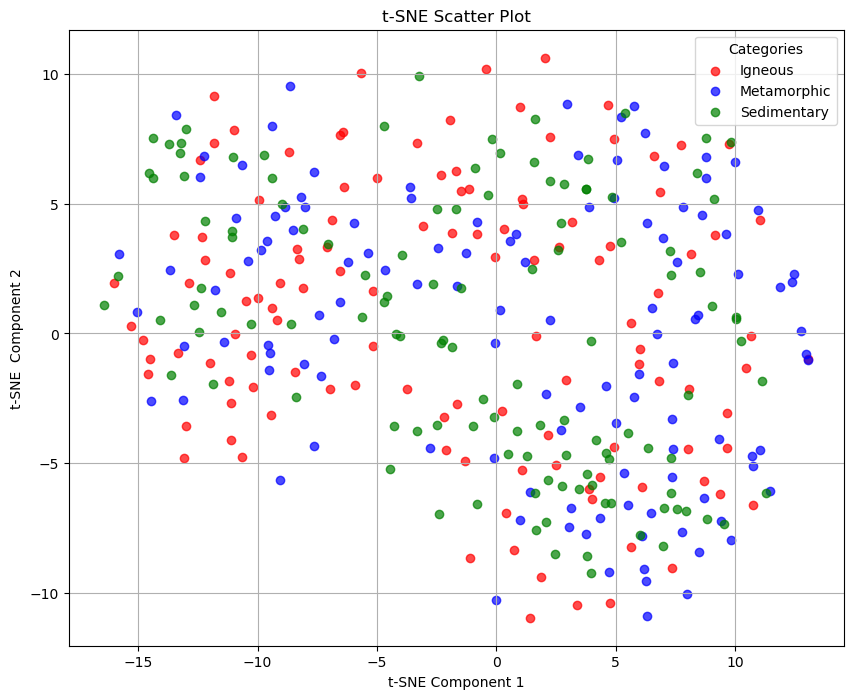

In [128]:
category_colors = {'Igneous': 'red', 'Metamorphic': 'blue', 'Sedimentary': 'green'}
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    idx = [i for i, label in enumerate(labels) if label == category]  # Use labels directly
    plt.scatter(tsne_result[idx, 0],tsne_result[idx, 1], c=color, label=category, alpha=0.7)

plt.title('t-SNE Scatter Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE  Component 2')
plt.legend(title="Categories")
plt.grid()
plt.show()

**t-SNE Scatter Plot with images**

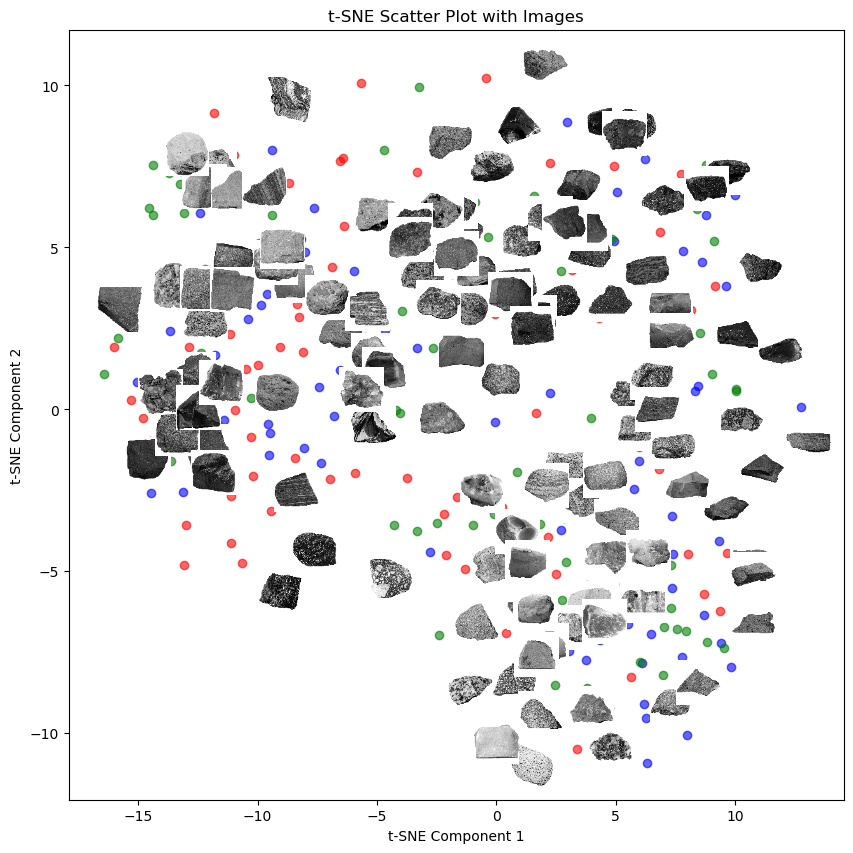

In [130]:
def plot_pca_with_images(data_2d, images, labels, colors, n_images=100):
    # Create a figure
    plt.figure(figsize=(10,10))

    # Plot scatter points with different colors for each label
    for i, (x, y) in enumerate(data_2d):
        plt.scatter(x, y, color=colors[labels[i]], alpha=0.6)

    # Add thumbnail images for some points
    for i in range(0, len(data_2d), max(1, len(data_2d) // n_images)):
        x, y = data_2d[i]
        img = images[i].reshape(64, 64)  # Reshape the image if necessary
        thumbnail = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap='gray', zoom=0.5), (x, y), frameon=False
        )
        plt.gca().add_artist(thumbnail)

    # Customize the plot
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Scatter Plot with Images")
    plt.show()


# Call the function with your t-SNE results
plot_pca_with_images(tsne_result,images,labels,category_colors)


**LLE Scatter Plot**

In [34]:
lle = LocallyLinearEmbedding(n_components=2)
lle_result = lle.fit_transform(images)

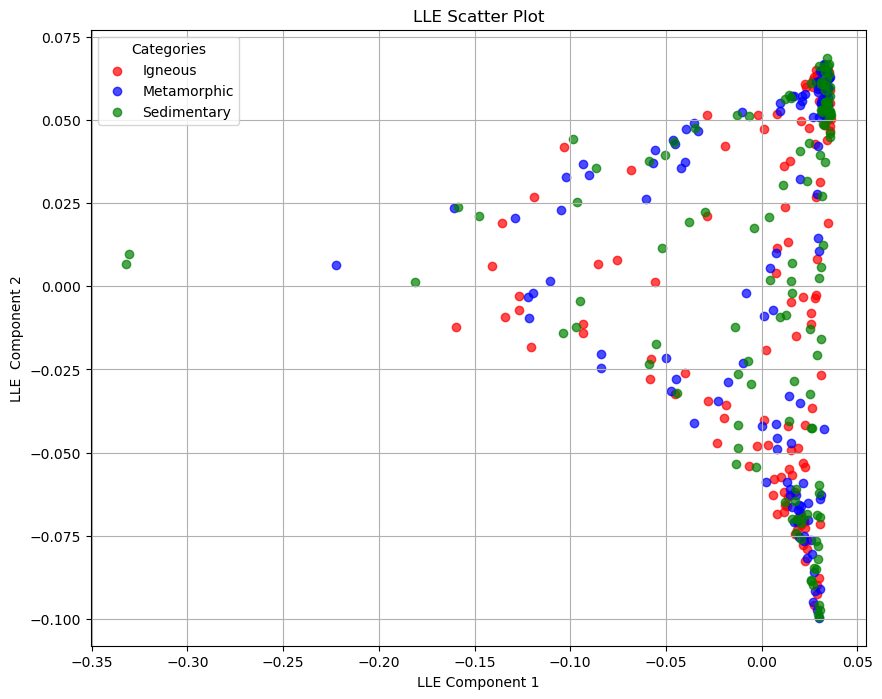

In [131]:
category_colors = {'Igneous': 'red', 'Metamorphic': 'blue', 'Sedimentary': 'green'}

plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    idx = [i for i, label in enumerate(labels) if label == category]  # Use labels directly
    plt.scatter(lle_result[idx, 0],lle_result[idx, 1], c=color, label=category, alpha=0.7)

plt.title('LLE Scatter Plot')
plt.xlabel('LLE Component 1')
plt.ylabel('LLE  Component 2')
plt.legend(title="Categories")
plt.grid()
plt.show()

**LLE Scatter Plot with Images**

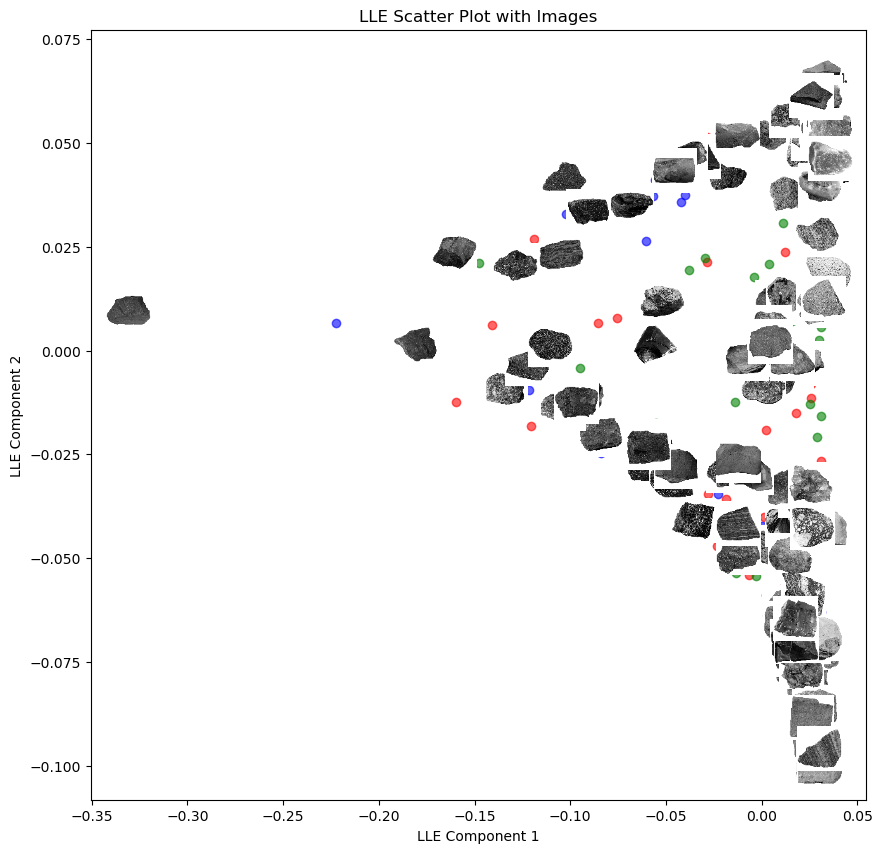

In [132]:
def plot_pca_with_images(data_2d, images, labels, colors, n_images=100):
    # Create a figure
    plt.figure(figsize=(10,10))

    # Plot scatter points with different colors for each label
    for i, (x, y) in enumerate(data_2d):
        plt.scatter(x, y, color=colors[labels[i]], alpha=0.6)

    # Add thumbnail images for some points
    for i in range(0, len(data_2d), max(1, len(data_2d) // n_images)):
        x, y = data_2d[i]
        img = images[i].reshape(64, 64)  # Reshape the image if necessary
        thumbnail = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap='gray', zoom=0.5), (x, y), frameon=False
        )
        plt.gca().add_artist(thumbnail)

    # Customize the plot
    plt.xlabel("LLE Component 1")
    plt.ylabel("LLE Component 2")
    plt.title("LLE Scatter Plot with Images")
    plt.show()


# Call the function with your LLE results
plot_pca_with_images(lle_result,images,labels,category_colors)


**MDS Scatter Plot**

In [39]:
mds = MDS(n_components=2)
mds_result = mds.fit_transform(images)

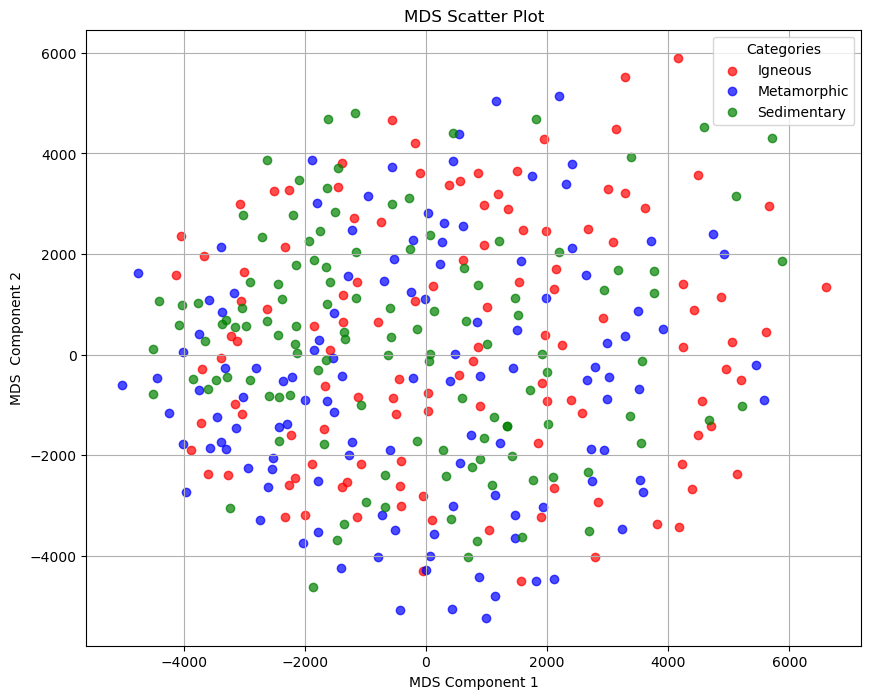

In [135]:
category_colors = {'Igneous': 'red', 'Metamorphic': 'blue', 'Sedimentary': 'green'}

plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    idx = [i for i, label in enumerate(labels) if label == category]  # Use labels directly
    plt.scatter(mds_result[idx, 0],mds_result[idx, 1], c=color, label=category, alpha=0.7)

plt.title('MDS Scatter Plot')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS  Component 2')
plt.legend(title="Categories")
plt.grid()
plt.show()

**MDS Scatter Plot with Images**

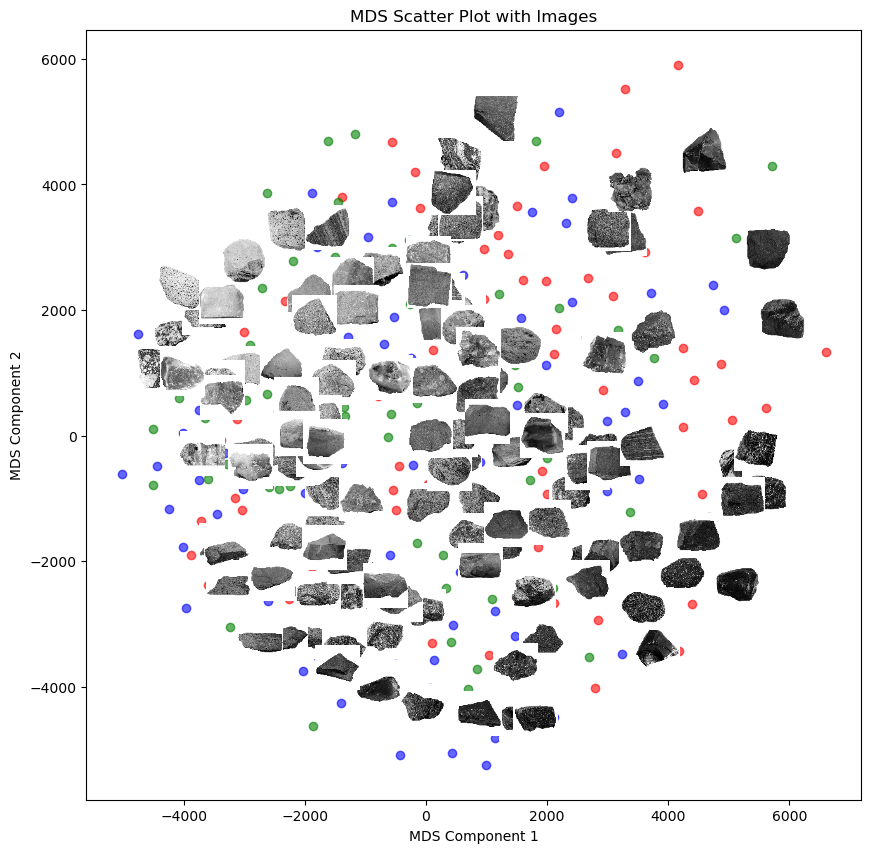

In [138]:
def plot_pca_with_images(data_2d, images, labels, colors, n_images=100):
    # Create a figure
    plt.figure(figsize=(10,10))

    # Plot scatter points with different colors for each label
    for i, (x, y) in enumerate(data_2d):
        plt.scatter(x, y, color=colors[labels[i]], alpha=0.6)

    # Add thumbnail images for some points
    for i in range(0, len(data_2d), max(1, len(data_2d) // n_images)):
        x, y = data_2d[i]
        img = images[i].reshape(64, 64)  # Reshape the image if necessary
        thumbnail = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap='gray', zoom=0.5), (x, y), frameon=False
        )
        plt.gca().add_artist(thumbnail)

    # Customize the plot
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title("MDS Scatter Plot with Images")
    plt.show()


# Call the function with your MDS results
plot_pca_with_images(mds_result,images,labels,category_colors)


**[3][C] Discuss your observations.**

**Observations**
1. **PCA 2D Scatter Plot**
PCA reduces the data into two principal components, showing a wide spread of points with overlap between igneous, metamorphic, and sedimentary categories.
The categories are not well-separated, indicating limited linear separability in the data.
2. **t-SNE Scatter Plot**
t-SNE captures non-linear relationships, forming more distinct clusters for each category.
While overlap still exists, the clustering shows better differentiation compared to PCA.
3. **LLE Scatter Plot**
LLE shows a linear arrangement along Component 1, with most points clustered tightly.
Categories are less distinguishable, except at the extremes, suggesting limited separability.
4. **MDS Scatter Plot**
The MDS plot shows a broad distribution of points with notable overlap between igneous, metamorphic, and sedimentary categories. Distinct clusters are not evident, indicating limited separability. This suggests that the data's dissimilarities are not well-aligned with clear category boundaries.

**[4] Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data. Report disparity for each of the three dimensionality reduction methods. Compute the correlation coefficient between each dimension of mtx1 and mtx2 for each of the three methods - display results in a table.**

In [46]:
matrix_with_human_data = np.loadtxt('C:/Users/Harsha Vardhan K/Downloads/mds_360.txt')

In [47]:
matrix_with_human_data.shape

(360, 8)

In [48]:
pca_8d=PCA(n_components=8)
matrix_with_pca_embeddings_data = pca_8d.fit_transform(images)
print(matrix_with_pca_embeddings_data.shape)
# Procrustes analysis
mtx1_pca, mtx2_pca, disparity_pca = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data)
print(f"Disparity (PCA): {disparity_pca}")

(360, 8)
Disparity (PCA): 0.8698890057092771


In [49]:
lle_8d = LocallyLinearEmbedding(n_components=8)
matrix_with_lle_embeddings_data = lle_8d.fit_transform(images)
print(matrix_with_lle_embeddings_data.shape)
# Procrustes analysis
mtx1_lle, mtx2_lle, disparity_lle = procrustes(matrix_with_human_data,matrix_with_lle_embeddings_data)
print(f"Disparity (LLE): {disparity_lle}")

(360, 8)
Disparity (LLE): 0.930638873650725


In [50]:
mds_8d = MDS(n_components=8, dissimilarity='euclidean')
matrix_with_mds_embeddings_data = mds_8d.fit_transform(images)
# Procrustes analysis
mtx1_mds, mtx2_mds, disparity_mds = procrustes(matrix_with_human_data,matrix_with_mds_embeddings_data)
print(f"Disparity (MDS): {disparity_mds}")

Disparity (MDS): 0.8981213200167721


You can see above matrix_with_human_data and matrix_with_pca_embeddings_data is 360 by 8.

In [140]:
# Data for the table
data = {
    "Method": ["PCA", "LLE", "MDS"],
    "Disparity": [disparity_pca, disparity_lle, disparity_mds],
    "All Correlations (8D)": [correlation_pca, correlation_lle, correlation_mds]
}
# Create a DataFrame
df = pd.DataFrame(data)
# Configure pandas to display full content
pd.set_option('display.max_colwidth', None)  # Do not truncate column content
pd.set_option('display.max_rows', None)  # Show all rows if needed
# Display the DataFrame
display(df)

,Method,Disparity,All Correlations (8D)
0,PCA,0.869889,"[-0.6526301061149149, -0.16386989581164949, 0.06878926993148347, 0.027598210976699265, 0.024789520477054232, -0.02350093977060002, -0.015556805065440778, 0.014177409064624738]"
1,LLE,0.930639,"[0.5518727413134472, -0.09862075835912389, -0.07151663734081382, 0.02488135603088831, -0.0010814288604573154, -0.01247133716205474, -0.00824792126279449, 0.04824089355048003]"
2,MDS,0.898121,"[-0.32326701358681975, 0.03372327938153459, 0.09667445183967666, 0.07833172051885977, 0.1693832890580013, 0.1962788207272459, 0.13329242890438447, -0.04133317131323648]"


**[5] Cluster the 360 images using K-Means.**

**[5][A] You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.**

In [115]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=0.90)  # Retain 90% of variance
reduced_images = pca.fit_transform(images)
print(f"Reduced Images Shape: {reduced_images.shape}")

Reduced Images Shape: (360, 147)


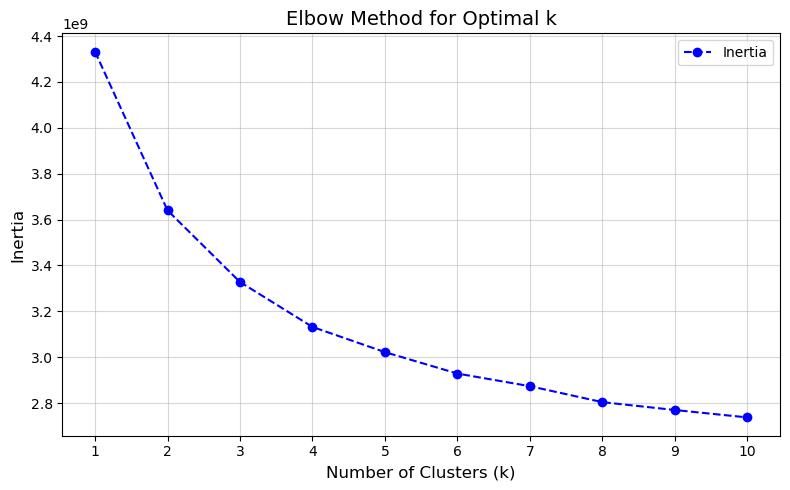

In [56]:
# Define the range of k values to test
k_values = range(1, 11)
# Store the inertia for each value of k
inertia_values = []
# Perform K-Means clustering for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_images)  # Use your dataset here (e.g., reduced_images)
    inertia_values.append(kmeans.inertia_)
# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--', color='blue', label='Inertia')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_values)  # Ensure all k values are shown on x-axis
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The plot shows the results of the elbow method for determining the optimal number of clusters (k)
for a dataset. The elbow point is clearly visible at k=3, indicating that this is the most suitable
number of clusters for the data

The inertia is not a good performance metric when trying to choose k
because it keeps getting lower as we increase k.

A more precise approach than using elbow is to use the silhouette score, which is the mean silhouette coefficient over all the instances.

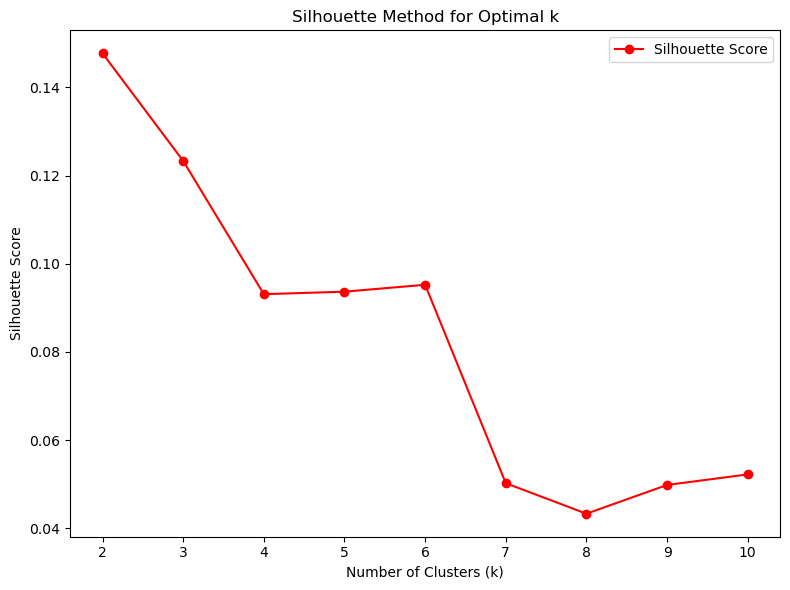

In [58]:
# Calculate Silhouette Scores for Different Values of k
k_values = range(2, 11)  # Range from 2 clusters to 10
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_images)  # reduced_images is your PCA-reduced data
    score = silhouette_score(reduced_images, kmeans.labels_)
    silhouette_scores.append(score)
# Plot the Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='red', label='Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

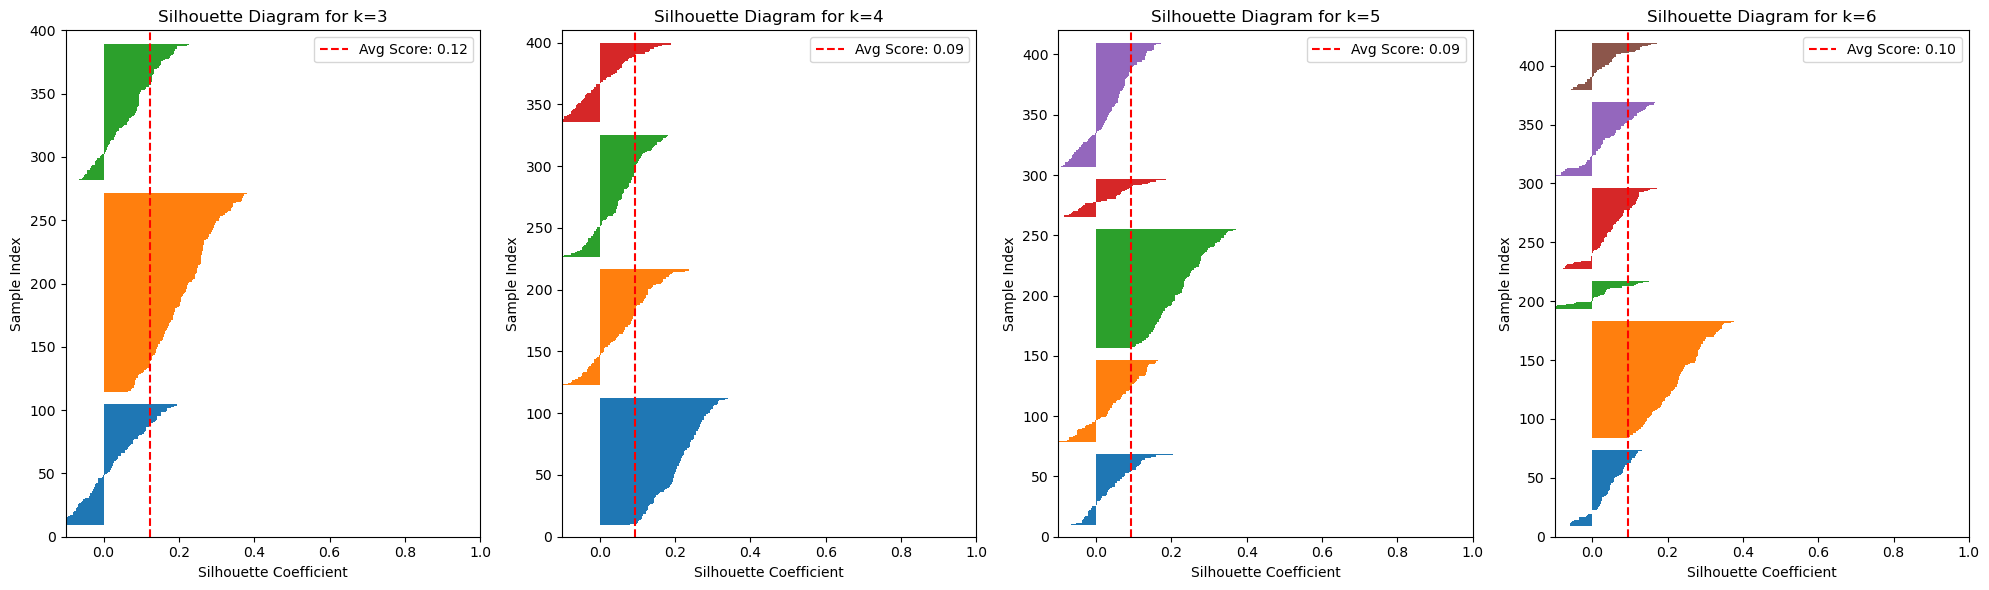

In [150]:
# Assume reduced_images is the PCA-reduced image data (from previous code)
k_values = [3, 4, 5, 6]  # Specify the k values for which you want to create the silhouette plot
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 6))
for i, k in enumerate(k_values):
    # Fit KMeans with the current k
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_images)
    # Get the silhouette scores for each sample
    silhouette_vals = silhouette_samples(reduced_images, kmeans.labels_)
    # Plot silhouette scores for all samples for the current k
    axes[i].set_xlim([-0.1, 1])
    axes[i].set_ylim([0, len(reduced_images) + (k + 1) * 10])
    axes[i].set_title(f"Silhouette Diagram for k={k}")
    axes[i].set_xlabel("Silhouette Coefficient")
    axes[i].set_ylabel("Sample Index")
    y_lower = 10
    for cluster_num in range(k):
        # Select the silhouette scores of samples for the current cluster
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == cluster_num]
        cluster_silhouette_vals.sort()
        size_cluster = len(cluster_silhouette_vals)
        # Plot the silhouette scores for the current cluster
        axes[i].barh(range(y_lower, y_lower + size_cluster), cluster_silhouette_vals, height=1.0, edgecolor='none')
        # Increment the y_lower to position the next cluster
        y_lower += size_cluster + 10
    # Add a vertical dashed line representing the average silhouette score for the current k
    avg_silhouette_score = silhouette_score(reduced_images, kmeans.labels_)
    axes[i].axvline(avg_silhouette_score, color='red', linestyle='--', label=f'Avg Score: {avg_silhouette_score:.2f}')
    axes[i].legend()
plt.tight_layout()
plt.show()

Based on the silhouette plot for 𝑘 = 3:

Higher Average Silhouette Score: The dashed red line (average silhouette score) for k=3 is noticeably higher compared to k=4, k=5, or k=6. This indicates better overall cluster cohesion and separation.

Balanced Cluster Sizes: The widths of the silhouette plots for k=3 suggest well-balanced clusters with fewer negative silhouette coefficients, signifying fewer misclassified samples compared to higher k values.

These factors make k=3 a better choice.

**[5][B] Set the number of clusters to 3 and report clustering accuracy.**

In [154]:
# Define a mapping from category names to numeric labels
category_mapping = {'Igneous': 0,'Metamorphic': 1,'Sedimentary': 2}
# You can map the labels to numeric labels using the mapping
numeric_labels = np.array([category_mapping[label] for label in labels])
# Now, 'numeric_labels' will contain the numeric values corresponding to the original categorical labels
print(numeric_labels)
print(numeric_labels.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(360,)


In [63]:
kmeans = KMeans(n_clusters=3, random_state=52)
predicted_labels = kmeans.fit_predict(reduced_images)

In [124]:
cluster_to_category = {}
for cluster_id in range(3):
    cluster_points = np.where(predicted_labels == cluster_id)[0]
    # Perform majority voting to determine the most frequent true label in the cluster
    most_common_label = np.bincount(numeric_labels[cluster_points]).argmax()  # Majority vote
    cluster_to_category[cluster_id] = most_common_label
# Map the predicted cluster labels to true category labels using the mapping
final_predicted_labels = np.array([cluster_to_category[label] for label in predicted_labels])
# Calculate accuracy by comparing the final predicted labels with the true numeric labels
accuracy = accuracy_score(numeric_labels, final_predicted_labels)
print(f"Clustering accuracy: {accuracy * 100:.2f}%")

Clustering accuracy: 39.72%


The KMeans algorithm was used to cluster the data into 3 clusters, corresponding to the three rock categories (igneous, metamorphic, sedimentary). Majority voting was applied within each cluster to map the predicted cluster labels to the true labels. The final predicted labels were compared to the actual labels to calculate the clustering accuracy, which resulted in a low accuracy of 39.72%. This indicates that the clustering did not align well with the true categories, likely due to overlapping features among classes.

**[6] Cluster the 360 images using EM**

**[6][A] You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.**

In [68]:
pca = PCA(n_components=0.90)  # Retain 90% variance
reduced_images = pca.fit_transform(images)
print(f"Reduced Images Shape: {reduced_images.shape}")

Reduced Images Shape: (360, 147)


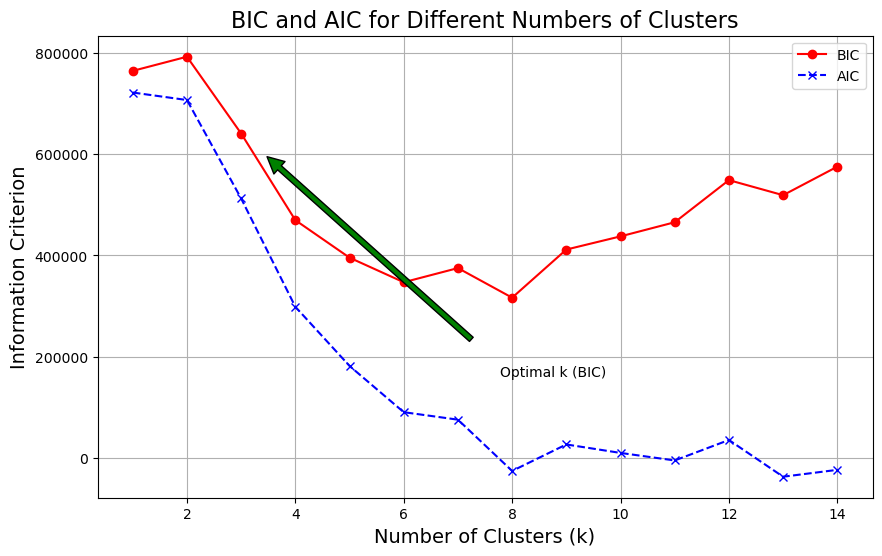

In [144]:
# Apply PCA to reduce dimensions, keeping 90% variance
pca = PCA(n_components=0.90)  # Keep 90% of the variance
x_reduced = pca.fit_transform(images)
# Convert reduced data to a DataFrame
pca_data = pd.DataFrame(x_reduced)
cluster_range = np.arange(1,15)
# Fit Gaussian Mixture Models for each cluster count and store the models
gmm_models = [GaussianMixture(n_components=k, covariance_type='full').fit(pca_data) for k in cluster_range]
# Calculate BIC and AIC for each model
bic_scores = [model.bic(pca_data) for model in gmm_models]
aic_scores = [model.aic(pca_data) for model in gmm_models]
# Plot the BIC and AIC scores for different values of k
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, bic_scores, marker='o', color='red', label="BIC")
plt.plot(cluster_range, aic_scores, marker='x', color='blue', linestyle='--', label="AIC")
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
# Annotate the point with the lowest BIC score
plt.annotate('Optimal k (BIC)',
             xy=(3, bic_scores[2]),  # Coordinates where BIC is minimum (k=3)
             xytext=(0.5, 0.3),
             textcoords='figure fraction',
             fontsize=10,
             arrowprops=dict(facecolor='green', shrink=0.1))
# Display the legend and show the plot
plt.legend()
plt.title('BIC and AIC for Different Numbers of Clusters', fontsize=16)
plt.grid(True)
plt.show()

From the BIC and AIC plot:
The BIC curve reaches a minimum at k=3. This suggests that a 3-cluster model provides a good fit to the data while also being relatively simple. Additionally, there's an elbow point in the curve around k=3, indicating that adding more clusters beyond 3 doesn't significantly improve the model's fit.

**[6][B] Set the number of clusters to 3 and report clustering accuracy.**

In [121]:
gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(reduced_images)
# Mapping for categories to numeric labels (0 for Igneous, 1 for Metamorphic, 2 for Sedimentary)
category_mapping = {'Igneous': 0, 'Metamorphic': 1, 'Sedimentary': 2}
numeric_labels = np.array([category_mapping[label] for label in labels])
# Mapping predicted cluster labels to actual labels using majority voting
cluster_to_category = {}
for cluster_id in range(3):
    cluster_points = np.where(gmm_labels == cluster_id)[0]  # Find points in this cluster
    most_common_label = np.bincount(numeric_labels[cluster_points]).argmax()  # Majority vote
    cluster_to_category[cluster_id] = most_common_label
# Map predicted cluster labels to true category labels
final_predicted_labels = np.array([cluster_to_category[label] for label in gmm_labels])
# Calculate the clustering accuracy
accuracy = accuracy_score(numeric_labels, final_predicted_labels)
print(f"Clustering accuracy: {accuracy * 100:.2f}%")

Clustering accuracy: 39.44%


The code applies the Gaussian Mixture Model (GMM) to cluster the dimensionally reduced images into three groups (one for each rock type: Igneous, Metamorphic, Sedimentary). It maps the predicted cluster labels to actual labels using majority voting based on the most common true label in each cluster. The final predicted labels are compared to the ground truth to calculate the clustering accuracy, which is 39.44%. This indicates moderate clustering performance.

**[6][C] Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).**

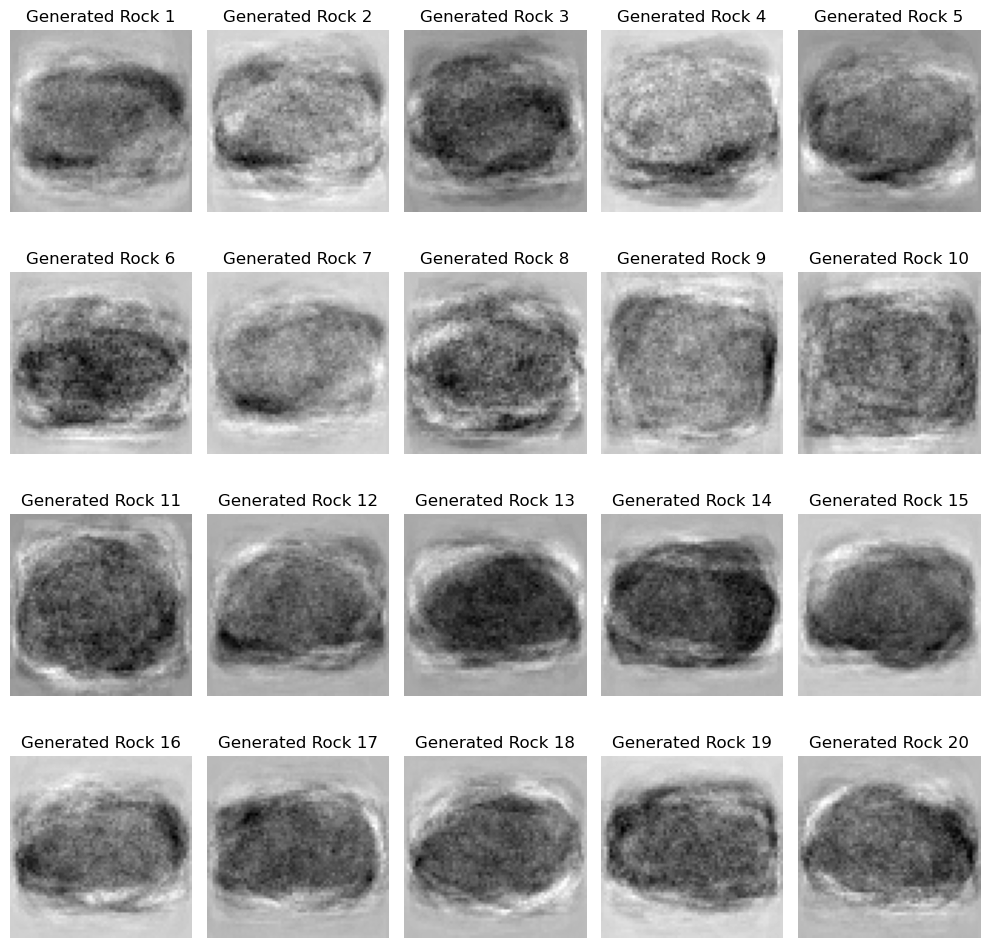

In [126]:
generated_points,_ = gmm.sample(20)  # Sample points in the reduced space (PCA space)
# Transform these points back to the original image space using PCA's inverse_transform
generated_images = pca.inverse_transform(generated_points)
# Visualize the 20 new generated rock images
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].reshape(64, 64), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Generated Rock {i+1}")
plt.tight_layout()
plt.show()

The code generates 20 new rock images using the sample() method of the Gaussian Mixture Model (GMM), which produces samples in the reduced PCA space based on the learned data distribution. These generated points are then transformed back to the original image space using the inverse_transform() method of PCA. The reconstructed images are visualized as grayscale images of size 
64×64 in a 4x5 grid. Each image represents a plausible synthetic rock generated by the GMM model, reflecting the data distribution learned during training. This demonstrates the ability of GMM and PCA to generate and reconstruct data points resembling the original dataset.

**[7] Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings).**

In [78]:
with zipfile.ZipFile('C:/Users/Harsha Vardhan K/Downloads/120 Rocks.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/120_Rocks')

In [158]:
def load_images_from_folder(folder, img_size=(64, 64)):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            # Assign labels based on the first letter of the filename
            if filename.startswith('I'):
                labels.append(0)  # Igneous
            elif filename.startswith('M'):
                labels.append(1)  # Metamorphic
            elif filename.startswith('S'):
                labels.append(2)  # Sedimentary
    return np.array(images), np.array(labels)

# Load data
img_size = (64, 64)
train_dir = '/content/360_Rocks'
val_dir = '/content/120_Rocks'

train_images, train_labels = load_images_from_folder(train_dir, img_size)
val_images, val_labels = load_images_from_folder(val_dir, img_size)

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=3)
val_labels = to_categorical(val_labels, num_classes=3)


In [89]:
# Build a feedforward neural network
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='relu'),  # Last hidden layer with 8 neurons
    Dense(3, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

The model is a convolutional neural network (CNN) built using the Sequential API, designed for a 3-class classification task. It begins with two Conv2D layers (32 and 64 filters) with ReLU activation, followed by MaxPooling2D layers to reduce spatial dimensions. The output is flattened into a 1D vector, passed through a Dense layer with 128 units, then an 8-unit layer, and finally, a 3-unit output layer for classification. The model has 1,626,211 trainable parameters, leveraging convolutional layers for feature extraction and dense layers for decision-making.

**[7][A] Report the training time (use code to do this).**

In [93]:
# Train the model and measure training time
start_time = time.time()
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    # Validation Data has been incorporated
    validation_data=(val_images, val_labels))
end_time = time.time()
# Report training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/20
12/12 [==============================] - 4s 136ms/step - loss: 1.1037 - accuracy: 0.3667 - val_loss: 1.0968 - val_accuracy: 0.3750
Epoch 2/20
12/12 [==============================] - 1s 69ms/step - loss: 1.0854 - accuracy: 0.4083 - val_loss: 1.0999 - val_accuracy: 0.3583
Epoch 3/20
12/12 [==============================] - 1s 67ms/step - loss: 1.0697 - accuracy: 0.4306 - val_loss: 1.1056 - val_accuracy: 0.3583
Epoch 4/20
12/12 [==============================] - 1s 66ms/step - loss: 1.0756 - accuracy: 0.3472 - val_loss: 1.0976 - val_accuracy: 0.3500
Epoch 5/20
12/12 [==============================] - 1s 67ms/step - loss: 1.0534 - accuracy: 0.4667 - val_loss: 1.0838 - val_accuracy: 0.4167
Epoch 6/20
12/12 [==============================] - 1s 63ms/step - loss: 1.0203 - accuracy: 0.5361 - val_loss: 1.0802 - val_accuracy: 0.4083
Epoch 7/20
12/12 [==============================] - 1s 69ms/step - loss: 1.0040 - accuracy: 0.5278 - val_loss: 1.0821 - val_accuracy: 0.4000
Epoch 8/20
1

As In the above data Validation data is incorporated and Accuracy is increasing with epochs.

**[7][B] Plot training and validation loss and accuracy as a function of training epochs.**

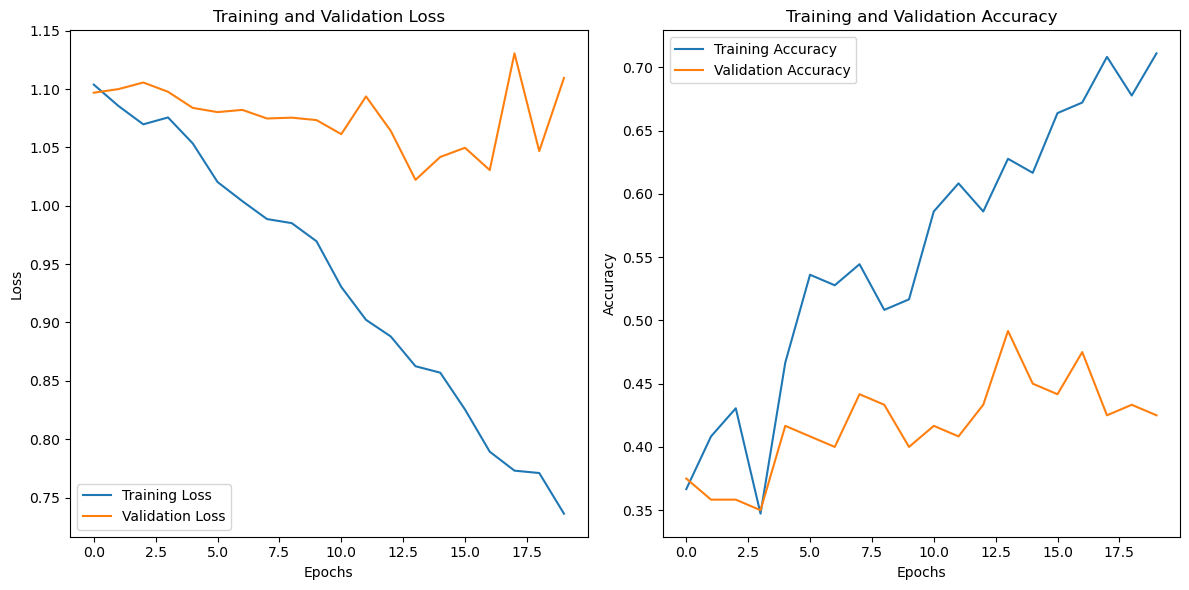

In [95]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


As You observe the graph train and validation loss decrease when the epoch increase and accuracy increase throughout the training.

**[7][C] How many parameters does the network have? How many of those parameters are bias parameters?**

In [99]:
# Calculate total, trainable, and bias parameters
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
bias_params = sum([np.prod(v.shape) for v in model.trainable_variables if 'bias' in v.name])

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Bias Parameters: {bias_params}")

Total Parameters: 1626211
Trainable Parameters: 1626211
Bias Parameters: 235


**[7][D] Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table.**

In [162]:
# Load human data
human_train_data = np.loadtxt('mds_360.txt')  # Path to your mds_360.txt (training data)
human_val_data = np.loadtxt('mds_120.txt')  # Path to your mds_120.txt (validation data)
def get_activations(model, data):
    activation_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    return activation_model.predict(data)
# Extract activations from the next-to-last layer (8 neurons)
train_activations = get_activations(model, train_images)  # Replace train_images with your actual train data
val_activations = get_activations(model, val_images)  # Replace val_images with your actual val data
# Ensure activations have the correct shape (num_samples, 8 neurons)
print(f"Train activations shape: {train_activations.shape}")
print(f"Validation activations shape: {val_activations.shape}")
# Perform Procrustes analysis
def procrustes_analysis(data1, data2):
    # Perform Procrustes analysis: aligning the two datasets
    mtx1, mtx2, disparity = procrustes(data1, data2)
    # Compute the correlation coefficients for each dimension
    correlations = [pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])]
    return disparity, correlations
# Perform Procrustes analysis on training and validation data
train_disparity, train_correlations = procrustes_analysis(human_train_data, train_activations)
val_disparity, val_correlations = procrustes_analysis(human_val_data, val_activations)
# Create a table to display results
results = pd.DataFrame({'Metric': ['Disparity'] + [f'Correlation Dimension {i+1}' for i in range(8)],  # 8 neurons
    'Training Data': [train_disparity] + train_correlations,
    'Validation Data': [val_disparity] + val_correlations})
print("Train Data Disparity:",train_disparity)
print("Validation Data Disparity:",val_disparity)
# Display the results
print(results)

4/4 [==============================] - 0s 21ms/step
Train activations shape: (360, 8)
Validation activations shape: (120, 8)
Train Data Disparity: 0.7609184996555953
Validation Data Disparity: 0.784308836104645
                    Metric  Training Data  Validation Data
0                Disparity       0.760918         0.784309
1  Correlation Dimension 1       0.639881         0.677429
2  Correlation Dimension 2       0.571321         0.549107
3  Correlation Dimension 3       0.418965         0.422930
4  Correlation Dimension 4       0.194034         0.228692
5  Correlation Dimension 5       0.375283         0.154128
6  Correlation Dimension 6       0.641072         0.693122
7  Correlation Dimension 7       0.397608         0.239314
8  Correlation Dimension 8       0.243862         0.257611
